
== Avaliação do modelo: Random Forest ==
Acurácia: 0.9510
              precision    recall  f1-score   support

           0       0.74      0.55      0.63        58
           1       0.96      0.98      0.97       697

    accuracy                           0.95       755
   macro avg       0.85      0.77      0.80       755
weighted avg       0.95      0.95      0.95       755

Matriz de Confusão:
[[ 32  26]
 [ 11 686]]


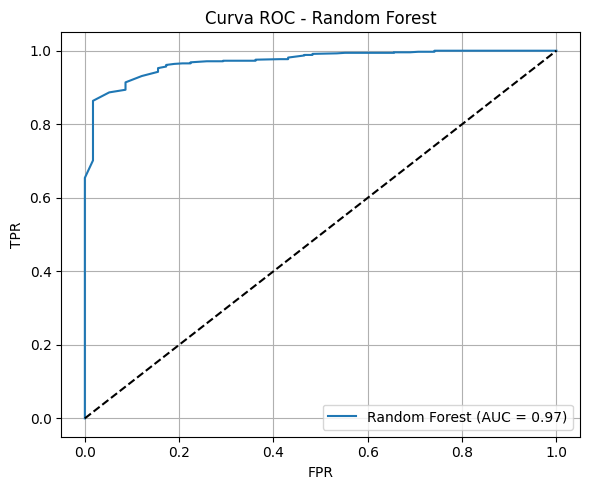


SVM - Melhor limiar para F1: 0.823

== Avaliação do modelo: SVM ==
Acurácia: 0.9682
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        58
           1       0.99      0.99      0.99       697

    accuracy                           0.98       755
   macro avg       0.92      0.92      0.92       755
weighted avg       0.98      0.98      0.98       755

Matriz de Confusão:
[[ 49   9]
 [  9 688]]


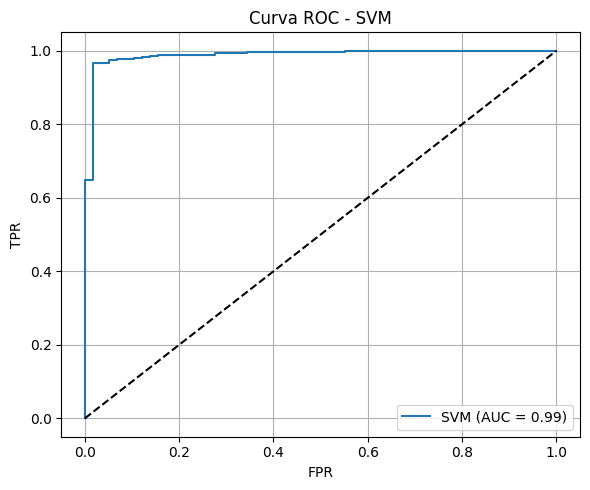


== Avaliação do modelo: XGBoost ==
Acurácia: 0.9603
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        58
           1       0.97      0.98      0.98       697

    accuracy                           0.96       755
   macro avg       0.87      0.84      0.85       755
weighted avg       0.96      0.96      0.96       755

Matriz de Confusão:
[[ 40  18]
 [ 12 685]]


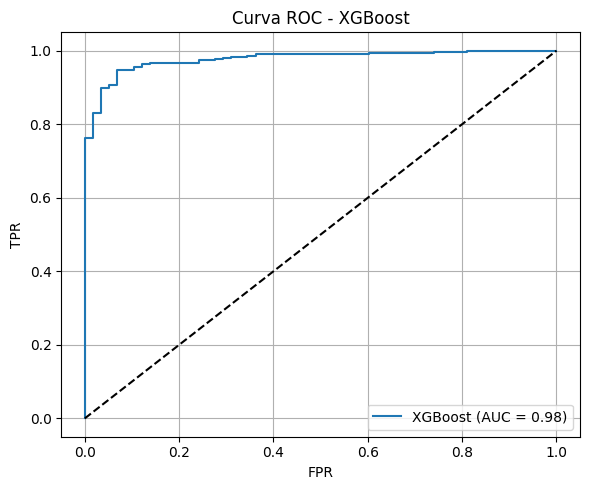


=== Validação Cruzada (5-Fold) ===
Random Forest: F1 médio = 0.9778 ± 0.0054
SVM: F1 médio = 0.9646 ± 0.0026
XGBoost: F1 médio = 0.9734 ± 0.0043


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')  # Ignora avisos para não poluir a saída

# 1. Carregamento do dataset
# Lê os dados do arquivo CSV contendo informações clínicas e alvo de classificação
df = pd.read_csv('Base_M43_Pratique_Hypothyroid.csv')

# 2. Substituição de '?' pela moda da coluna (valor mais frequente)
# Isso trata valores ausentes em variáveis categóricas
for col in df.columns:
    valores_validos = df[col][df[col] != '?']
    if not valores_validos.empty:
        moda = valores_validos.mode()
        if not moda.empty:
            df[col] = df[col].replace('?', moda[0])

# 3. Conversão de colunas numéricas de texto para float
num_cols = ['age', 'T3', 'TT4', 'T4U', 'FTI']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # converte ou insere NaN

# 4. Mapeamento de valores binários ('t'/'f') e 'sex' ('M'/'F') para 1 e 0
# Facilita o uso dos dados em algoritmos que só aceitam números
df.replace({'f': 0, 't': 1}, inplace=True)
if 'sex' in df.columns:
    df['sex'] = df['sex'].map({'F': 0, 'M': 1})

# 5. Separação de variáveis independentes (X) e alvo (y)
X = df.drop(columns=['binaryClass'])  # remove a coluna alvo
y_str = df['binaryClass']  # coluna alvo original (com 'N' ou 'P')
y = y_str.map({'N': 0, 'P': 1})  # mapeia para 0 e 1

# 6. One-hot encoding para variáveis categóricas restantes
# Cria colunas dummies para representar categorias com 0s e 1s
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 7. Divisão em treino e teste com estratificação (preserva proporção de classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Normalização das colunas numéricas com média 0 e desvio padrão 1
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 9. Aplicação do SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 10. Definição de três modelos para comparação
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 11. Avaliação dos modelos: treino, métricas e curva ROC
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)  # Treina o modelo
    y_probs = model.predict_proba(X_test)[:, 1]  # Obtém probabilidades da classe positiva

    # Para SVM ajusta o threshold baseado no melhor F1-score
    if name == 'SVM':
        from sklearn.metrics import precision_recall_curve
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_thresh = thresholds[np.argmax(f1_scores)]
        y_pred = (y_probs >= best_thresh).astype(int)
        print(f'\n{name} - Melhor limiar para F1: {best_thresh:.3f}')
    else:
        y_pred = model.predict(X_test)  # Previsão direta para RF e XGB

    # Impressão das métricas de avaliação
    print(f'\n== Avaliação do modelo: {name} ==')
    print(f'Acurácia: {model.score(X_test, y_test):.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))
    print('Matriz de Confusão:')
    print(confusion_matrix(y_test, y_pred))

    # Cálculo e plot da curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # linha de referência aleatória
    plt.title(f'Curva ROC - {name}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 12. Validação cruzada com 5 folds para verificar estabilidade dos modelos
print("\n=== Validação Cruzada (5-Fold) ===")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    print(f'{name}: F1 médio = {scores.mean():.4f} ± {scores.std():.4f}')
